# Predicting sentiments from product reviews
The dataset used in this notebook can be found here [amazon_baby.csv](https://d396qusza40orc.cloudfront.net/phoenixassets/amazon_baby.csv)

In [1]:
import pandas as pd
import numpy as np

In [2]:
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline

Import necessary package for words preprocessing (cleaning text):
- Import re (regular expression, for removing punctuation)
- Import nltk and download stopwords corpus (remove stopwords such as "and", "the", etc)

In [3]:
import re, collections
import nltk
#nltk.download()
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [5]:
products = pd.read_csv("./data/amazon_baby.csv")

## A bit of data exploration

In [6]:
products.head(5)

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [7]:
products.count()

name      183213
review    182702
rating    183531
dtype: int64

Some reviews are obviously **missing (NaN)**. Replace NaN reviews with " " to avoid errors when processing texts later on.

In [8]:
products["review"].fillna(" ",inplace=True)

## Create bag of words for reviews

### Clean the reviews first
- Remove punctuation (using regular expression)
- Change review to lowercase only and split text in words
- (optionally remove stop words. This is not done in the course)
- Finally Put all reviews in a list (reviews)

In [9]:
def clean_review(raw_review, stopswrd):
    review = re.sub("[^a-zA-Z]"," ",raw_review)
    review = review.lower().split()
    review = [w for w in review if not w in stopswrd]
    return(" ".join(review))

In [10]:
stopswrd = set(stopwords.words("english"))

In [11]:
reviews = []
num_reviews = products.shape[0]

In [12]:
for i in range(0,num_reviews):
    reviews.append(clean_review(products["review"][i],stopswrd))

### The bag of words
Create a data frame containing bag of words for each review and add the column to the **products** DataFrame.

In [13]:
%%time
bagofwords = pd.DataFrame((str(dict(collections.Counter(re.findall(r"\w+", txt)))) for txt in reviews),columns=["word_count"])

Wall time: 5.56 s


In [14]:
products.insert(len(products.columns),"word_count",bagofwords)

In [15]:
products.head(5)

,name,review,rating,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{'fab': 1, 'keeping': 1, 'texture': 1, 'usingt..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'early': 1, 'planet': 1, 'love': 1, 'came': 1..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'full': 1, 'would': 1, 'anyone': 1, 'quilt': ..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'daughter': 1, 'losing': 1, 'love': 2, 'produ..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'help': 1, 'love': 1, 'ween': 1, 'book': 2, '..."


## Most Frequent products reviewed (top 20)
- Slice products to retain only name and review columns
- Count on review
- Sort on review and slice the last 20 rows (by Default sorting is ascending, i.e. top20 will be last 20 rows)

In [16]:
data = products.loc[:,["name","review"]]
data = data.groupby("name").count().sort_values("review")
data = data.iloc[len(data)-20:len(data)]

In [17]:
barh_bottom = np.arange(len(data))
barh_width = data["review"]

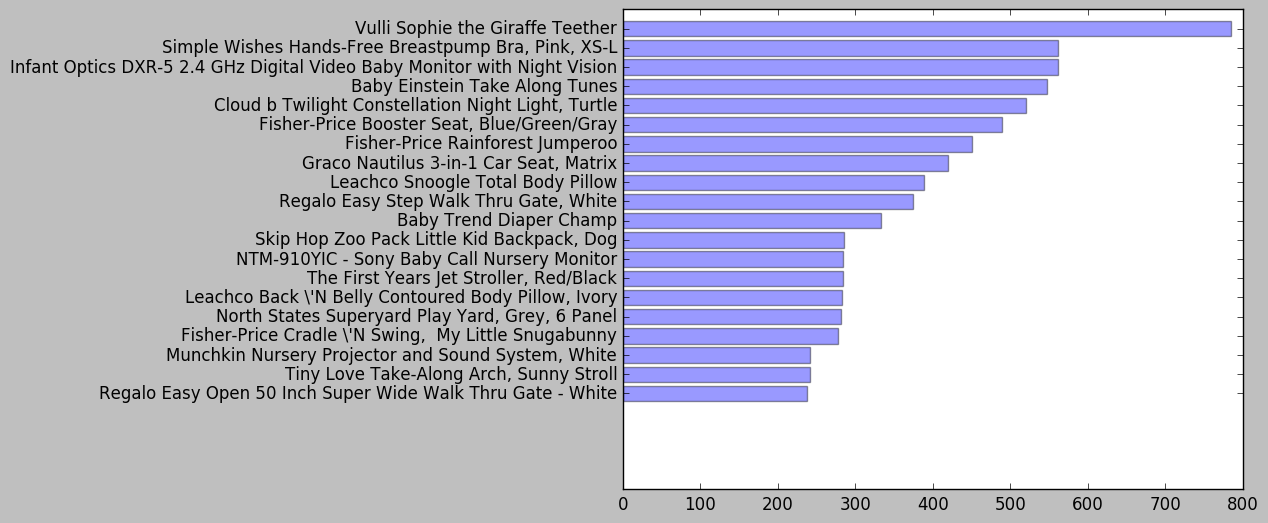

In [18]:
plt.rcdefaults()
plt.barh(barh_bottom, barh_width, height = 0.8, align='center', alpha=0.4)
plt.yticks(barh_bottom, data.index);
plt.show()

## Exploring Vulli Sophie

In [19]:
sophie = products[products["name"] == "Vulli Sophie the Giraffe Teether"]
print("Number of review for Vulli Sophie:",sophie.shape[0])

Number of review for Vulli Sophie: 785


In [20]:
data = sophie.loc[:,["name","rating"]]
data = data.groupby("rating").count().sort_values("name")

In [21]:
barh_bottom = np.arange(len(data))
barh_width = data["name"]

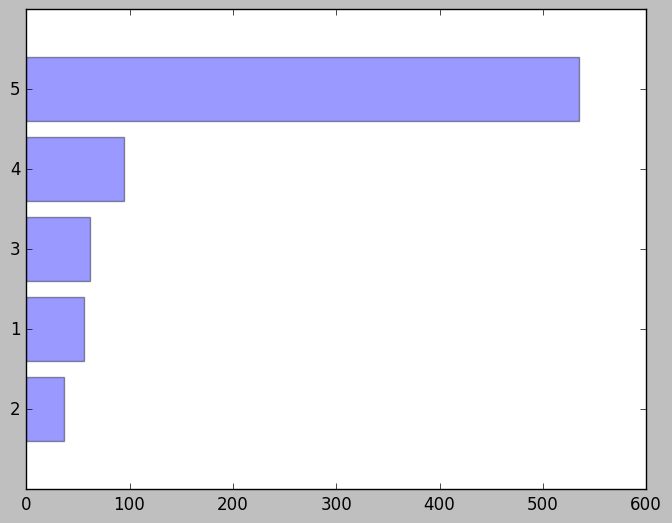

In [22]:
plt.barh(barh_bottom, barh_width, height = 0.8, align='center', alpha=0.4)
plt.yticks(barh_bottom, data.index);
plt.show()

## Train a sentiment classifier

### Use sklearn then to create bag of words
Each review will lead to a creation of a **[max_features]** row vector holding the counts for each word of the vocabulary. **[max_features]** being the maximum number of word to include into the vocabulary.
The result is a **sparse** matrix of which shape is (**nb_products_review**,**max_features**)

**Important to make that step here (and not AFTER slicing products) so that we have same row indexes for products and word_count, as we'll use indexes latter for predictions**

In [23]:
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,
                             stop_words = stopswrd,
                             max_features = 5000
                            )

In [24]:
%%time
words_count = vectorizer.fit_transform(products.loc[:,"review"])

Wall time: 8.84 s


In [25]:
print("products shape:",products.shape," words_count shape:",words_count.shape)

products shape: (183531, 4)  words_count shape: (183531, 5000)


### Define what's a positive and a negative sentiment
Define rating >= 4 as positive sentiment (1), rating < 4 as negative sentiment (0), remove "3" rating.

In [26]:
products["sentiment"]=0
products.loc[products.rating >= 4, "sentiment"] = 1
products = products[products.loc[:,"rating"] != 3]

Reduce words_count accordingly to products (i.e. remove appropriate rows).

In [27]:
words_count = words_count[products.index]

In [28]:
print("products shape:",products.shape," words_count shape:",words_count.shape)

products shape: (166752, 5)  words_count shape: (166752, 5000)


In [50]:
products.head(5)

,name,review,rating,word_count,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'early': 1, 'planet': 1, 'love': 1, 'came': 1...",1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'full': 1, 'would': 1, 'anyone': 1, 'quilt': ...",1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'daughter': 1, 'losing': 1, 'love': 2, 'produ...",1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'help': 1, 'love': 1, 'ween': 1, 'book': 2, '...",1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'daughter': 1, 'help': 2, 'favorite': 1, 'los...",1


## Logistic Regression

In [29]:
lr = LogisticRegression()

In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(words_count,products["sentiment"],
                                                    test_size = 0.2,random_state=0)
lr.fit(X_train, y_train)

Wall time: 9.56 s


#### Logistic Regression scores
- Accuracy
- Precision: True Positives/(True Positives + False Positives)
- Recall:    True Positives/(True Positives + False Negatives)
- F1:        2\*Precision\*Recall/(Precision + Recall)

In [31]:
print("Mean accuracy:",lr.score(X_test,y_test))

y_predict = lr.predict(X_test)

print("Accuracy:",accuracy_score(y_test,y_predict),
      "number of correct predictions:",accuracy_score(y_test,y_predict, normalize=False))
print("Precision:",precision_score(y_test,y_predict))
print("Recall:",recall_score(y_test,y_predict))
print("F1:",f1_score(y_test,y_predict))

Mean accuracy: 0.923090761896
Accuracy: 0.923090761896 number of correct predictions: 30786
Precision: 0.941941315533
Recall: 0.968023151953
F1: 0.954804151322


#### Confusion matrix

In [32]:
cm = confusion_matrix(y_test,y_predict)
print("True Positives:",cm[0][0])
print("False Positives:",cm[1][0])
print("True Negatives:",cm[1][1])
print("False Negatives:",cm[0][1])

True Positives: 3692
False Positives: 895
True Negatives: 27094
False Negatives: 1670


#### ROC (Receiver Operating Characteritic) curve
roc_curve metric return:
- **fpr**, array of false positive rate
- **tpr**, array of true positive rate
- **thresholds**, array of thresholds for the decision function 

Get probability for being a positive (column 1 of the output of **lr.predict_proba**)

In [33]:
y_predict_proba = lr.predict_proba(X_test)[:,1]

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

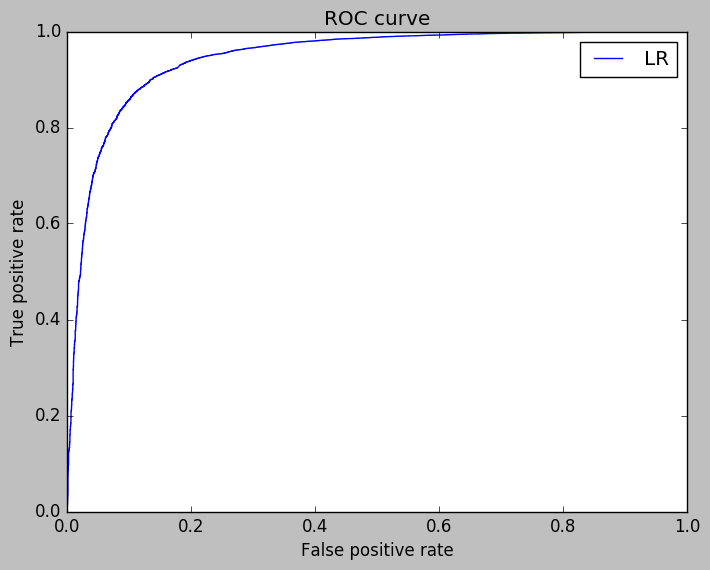

In [35]:
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show();

## Applying our model to Vulli Sophie
- Reviews of Vulli Sophie (X_sophie) are extracted from words_count (using index of sophie dataframe).
- Add predictions probabilities to the sophie dataframe

In [36]:
X_sophie = words_count[sophie.index]

In [37]:
sophie["predicted_sentiment"] = lr.predict_proba(X_sophie)[:,1]

In [38]:
sophie.head()

,name,review,rating,word_count,predicted_sentiment
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,"{'teething': 1, 'parts': 1, 'likes': 1, 'espec...",0.998094
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,"{'help': 1, 'clean': 1, 'right': 1, 'seems': 1...",0.972396
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,"{'quite': 1, 'baby': 2, 'latex': 4, 'easily': ...",0.986719
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5,"{'daughter': 1, 'another': 1, 'lost': 1, 'love...",0.991816
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,"{'day': 1, 'even': 2, 'take': 1, 'almost': 1, ...",0.998157


### Sort the reviews based on the predicted sentiment

In [53]:
sophie_sorted = sophie.sort_values("predicted_sentiment",ascending=False)

In [57]:
sophie_sorted.head()

,name,review,rating,word_count,predicted_sentiment
34792,Vulli Sophie the Giraffe Teether,I am very angry to find out that this teether ...,1,"{'find': 1, 'pink': 1, 'however': 1, 'totally'...",1.0
34840,Vulli Sophie the Giraffe Teether,My daughter is going through some MAJOR teethi...,3,"{'daughter': 2, 'teething': 1, 'pre': 1, 'mont...",1.0
34606,Vulli Sophie the Giraffe Teether,"sophie is a baby\'s best friend. cute, squeak...",5,"{'squeaky': 1, 'drool': 1, 'chew': 1, 'baby': ...",1.0
34466,Vulli Sophie the Giraffe Teether,After getting this for my baby and after she s...,1,"{'batch': 1, 'find': 1, 'distinguish': 1, 'run...",1.0
34538,Vulli Sophie the Giraffe Teether,"As a new parent, we read all the reviews first...",2,"{'drool': 1, 'case': 1, 'love': 1, 'bought': 1...",1.0


In [59]:
sophie_sorted.loc[34466,"review"]

"After getting this for my baby and after she sucked a good amount of the paint off I read that amazon\\'s Sophie\\'s were fake.  I scoured the Internet looking for ways to distinguish the real Sophie\\'s from the fakes.  I found that this Sophie had the right markings, no obvious mistakes and came with one of the right lot or batch number so I chalked up the running eye paint to it being natural.  But then I saw Sophie\\'s in a local Children\\'s retail store and I realized mine was fake after all!  The real Sophie\\'s eyes do not smear when rubbed or sucked on.  The real Sophie was slightly more slender and toned looking.  She was more flexible, you can easily fold her over and squeeze her cheeks in making her squeak with very little pressure. Just tapping her on the body while she is laying down makes her squeak, whereas the fake Sophie is slightly stiffer so you have to deliberately squeeze her to make her squeak. Do not take the chance with these, find a local retailer through the

In [60]:
products.loc[34466,"review"]

"After getting this for my baby and after she sucked a good amount of the paint off I read that amazon\\'s Sophie\\'s were fake.  I scoured the Internet looking for ways to distinguish the real Sophie\\'s from the fakes.  I found that this Sophie had the right markings, no obvious mistakes and came with one of the right lot or batch number so I chalked up the running eye paint to it being natural.  But then I saw Sophie\\'s in a local Children\\'s retail store and I realized mine was fake after all!  The real Sophie\\'s eyes do not smear when rubbed or sucked on.  The real Sophie was slightly more slender and toned looking.  She was more flexible, you can easily fold her over and squeeze her cheeks in making her squeak with very little pressure. Just tapping her on the body while she is laying down makes her squeak, whereas the fake Sophie is slightly stiffer so you have to deliberately squeeze her to make her squeak. Do not take the chance with these, find a local retailer through the

In [61]:
products.loc[34466,"word_count"]

"{'batch': 1, 'find': 1, 'distinguish': 1, 'running': 1, 'children': 1, 'internet': 1, 'smear': 1, 'eye': 1, 'read': 1, 'markings': 1, 'fake': 4, 'eyes': 1, 'retailer': 1, 'makes': 1, 'tapping': 1, 'site': 2, 'cheeks': 1, 'slender': 1, 'realized': 1, 'little': 1, 'amount': 1, 'obvious': 1, 'pressure': 1, 'fakes': 1, 'making': 1, 'easily': 1, 'number': 1, 'paint': 2, 'official': 1, 'natural': 1, 'hope': 1, 'website': 1, 'toys': 1, 'squeeze': 2, 'amazon': 1, 'make': 1, 'getting': 1, 'ways': 1, 'looking': 2, 'store': 1, 'local': 2, 'take': 1, 'flexible': 1, 'deliberately': 1, 'came': 1, 'laying': 1, 'slightly': 2, 'sucked': 2, 'good': 1, 'squeak': 3, 'one': 1, 'box': 1, 'chance': 1, 'vulli': 1, 'retail': 1, 'www': 1, 'mistakes': 1, 'right': 2, 'rubbed': 1, 'fold': 1, 'whereas': 1, 'toned': 1, 'baby': 1, 'sophie': 8, 'stiffer': 1, 'order': 1, 'body': 1, 'helps': 1, 'chalked': 1, 'scoured': 1, 'found': 1, 'saw': 1, 'mine': 1, 'real': 3, 'com': 1, 'lot': 1}"

In [58]:
bagofwords_df[34466]

{'amazon': 1,
 'amount': 1,
 'baby': 1,
 'batch': 1,
 'body': 1,
 'box': 1,
 'came': 1,
 'chance': 1,
 'cheeks': 1,
 'children': 1,
 'com': 1,
 'easily': 1,
 'eye': 1,
 'eyes': 1,
 'fake': 4,
 'find': 1,
 'flexible': 1,
 'fold': 1,
 'found': 1,
 'getting': 1,
 'good': 1,
 'helps': 1,
 'hope': 1,
 'internet': 1,
 'laying': 1,
 'little': 1,
 'local': 2,
 'looking': 2,
 'lot': 1,
 'make': 1,
 'makes': 1,
 'making': 1,
 'markings': 1,
 'mine': 1,
 'natural': 1,
 'number': 1,
 'obvious': 1,
 'one': 1,
 'order': 1,
 'paint': 2,
 'pressure': 1,
 'read': 1,
 'real': 3,
 'realized': 1,
 'retail': 1,
 'retailer': 1,
 'right': 2,
 'rubbed': 1,
 'running': 1,
 'saw': 1,
 'site': 2,
 'slightly': 2,
 'sophie': 8,
 'squeak': 3,
 'squeeze': 2,
 'store': 1,
 'sucked': 2,
 'take': 1,
 'toys': 1,
 'ways': 1,
 'website': 1,
 'whereas': 1,
 'www': 1}

# -------------

**words_count** is a sparse matrix, let's transform it to a numpy array for creating a "word_count" column as in the course

In [39]:
%%time
words_count_a = words_count.toarray()

Wall time: 848 ms


In [40]:
words_count_a.shape

(166752, 5000)

### Transform sklearn bag of words
Our bag of words is created (**words\_count** in association with the vocabulary learned by CountVectorizer instance, i.e. **vectorizer.vocabulary_**), but let's do some transformation to reproduce the course notebook (additional column with bag of words as a dictionnary for each review).

In [41]:
def to_dict(review):
    dic = pd.DataFrame(vectorizer.get_feature_names(), columns = ["vocabulary"])
    dic.insert(1,"count",review.reshape(-1,1))
    dic = dic[dic["count"]>0]
    i = iter(dic.to_dict(orient="split")["data"])
    return{k:v for k,v in i}

In [42]:
%%time
bagofwords_df = pd.DataFrame(words_count_a,products.index).apply(to_dict, axis=1)

Wall time: 10min 16s
